In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
#import libraries
import keras
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
#import splitfolders # or import splitfolders
#input_folder = "data"
#output = "output/" #where you want the split datasets saved. one will be created if it does not exist or none is set

#splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .3,)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 13999 files [00:06, 2325.66 files/s]


In [4]:
train_path = "output/train"
test_path = "output/val"

In [13]:
IMAGE_SIZE = [128,128]

In [14]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 8397 images belonging to 6 classes.
Found 5602 images belonging to 6 classes.


In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [51]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# VGG16

In [19]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3))

In [20]:
#Create new model on top
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout

base_model.trainable = False

model3 = Sequential()
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model3.add(Dropout(0.35))
model3.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model3.add(Dropout(0.35))
model3.add(Dense(6,activation='softmax',kernel_initializer='glorot_normal'))

In [21]:
model3.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=["accuracy",f1_m,precision_m, recall_m])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              16779264  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [23]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=100, steps_per_epoch=len(train_set), validation_steps=len(test_set))#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/100
4199/4199 [==============================] - 63s 15ms/step - loss: 1.5602 - accuracy: 0.3717 - f1_m: 0.1773 - precision_m: 0.2464 - recall_m: 0.1428 - val_loss: 1.4498 - val_accuracy: 0.4202 - val_f1_m: 0.2062 - val_precision_m: 0.2888 - val_recall_m: 0.1649
Epoch 2/100
4199/4199 [==============================] - 63s 15ms/step - loss: 1.4417 - accuracy: 0.4244 - f1_m: 0.2487 - precision_m: 0.3373 - recall_m: 0.2043 - val_loss: 1.3850 - val_accuracy: 0.4564 - val_f1_m: 0.2714 - val_precision_m: 0.3718 - val_recall_m: 0.2212
Epoch 3/100
4199/4199 [==============================] - 64s 15ms/step - loss: 1.3581 - accuracy: 0.4649 - f1_m: 0.3092 - precision_m: 0.4133 - recall_m: 0.2572 - val_loss: 1.3498 - val_accuracy: 0.4697 - val_f1_m: 0.2798 - val_precision_m: 0.3788 - val_recall_m: 0.2303
Epoch 4/100
4199/4199 [==============================] - 64s 15ms/step - loss: 1.2950 - accuracy: 0.4889 - f1_m: 0.3429 - precision_m: 0.4525 - recall_m: 0.2880 - val_loss: 1.3517 - val_a

4199/4199 [==============================] - 67s 16ms/step - loss: 0.4659 - accuracy: 0.8298 - f1_m: 0.8129 - precision_m: 0.8735 - recall_m: 0.7826 - val_loss: 2.0280 - val_accuracy: 0.5975 - val_f1_m: 0.5721 - val_precision_m: 0.6280 - val_recall_m: 0.5441
Epoch 62/100
4199/4199 [==============================] - 65s 15ms/step - loss: 0.4922 - accuracy: 0.8258 - f1_m: 0.8082 - precision_m: 0.8728 - recall_m: 0.7759 - val_loss: 2.0625 - val_accuracy: 0.6019 - val_f1_m: 0.5794 - val_precision_m: 0.6375 - val_recall_m: 0.5503
Epoch 63/100
4199/4199 [==============================] - 63s 15ms/step - loss: 0.4772 - accuracy: 0.8279 - f1_m: 0.8122 - precision_m: 0.8777 - recall_m: 0.7795 - val_loss: 1.9725 - val_accuracy: 0.6059 - val_f1_m: 0.5706 - val_precision_m: 0.6351 - val_recall_m: 0.5384
Epoch 64/100
4199/4199 [==============================] - 63s 15ms/step - loss: 0.4858 - accuracy: 0.8198 - f1_m: 0.8036 - precision_m: 0.8656 - recall_m: 0.7726 - val_loss: 2.0737 - val_accuracy: 

In [24]:
model3.save('vgg16.h5')

In [52]:
dl_acc = hist3.history["accuracy"][99]
dl_prec = hist3.history["precision_m"][99]
dl_rec = hist3.history["recall_m"][99]
dl_f1 = hist3.history["f1_m"][99]

storeResults('Train Acc - VGG16',dl_acc,dl_prec,dl_rec,dl_f1)

In [53]:
dl_acc = hist3.history["val_accuracy"][99]
dl_prec = hist3.history["val_precision_m"][99]
dl_rec = hist3.history["val_recall_m"][99]
dl_f1 = hist3.history["val_f1_m"][99]

storeResults('Valid Acc - VGG16',dl_acc,dl_prec,dl_rec,dl_f1)

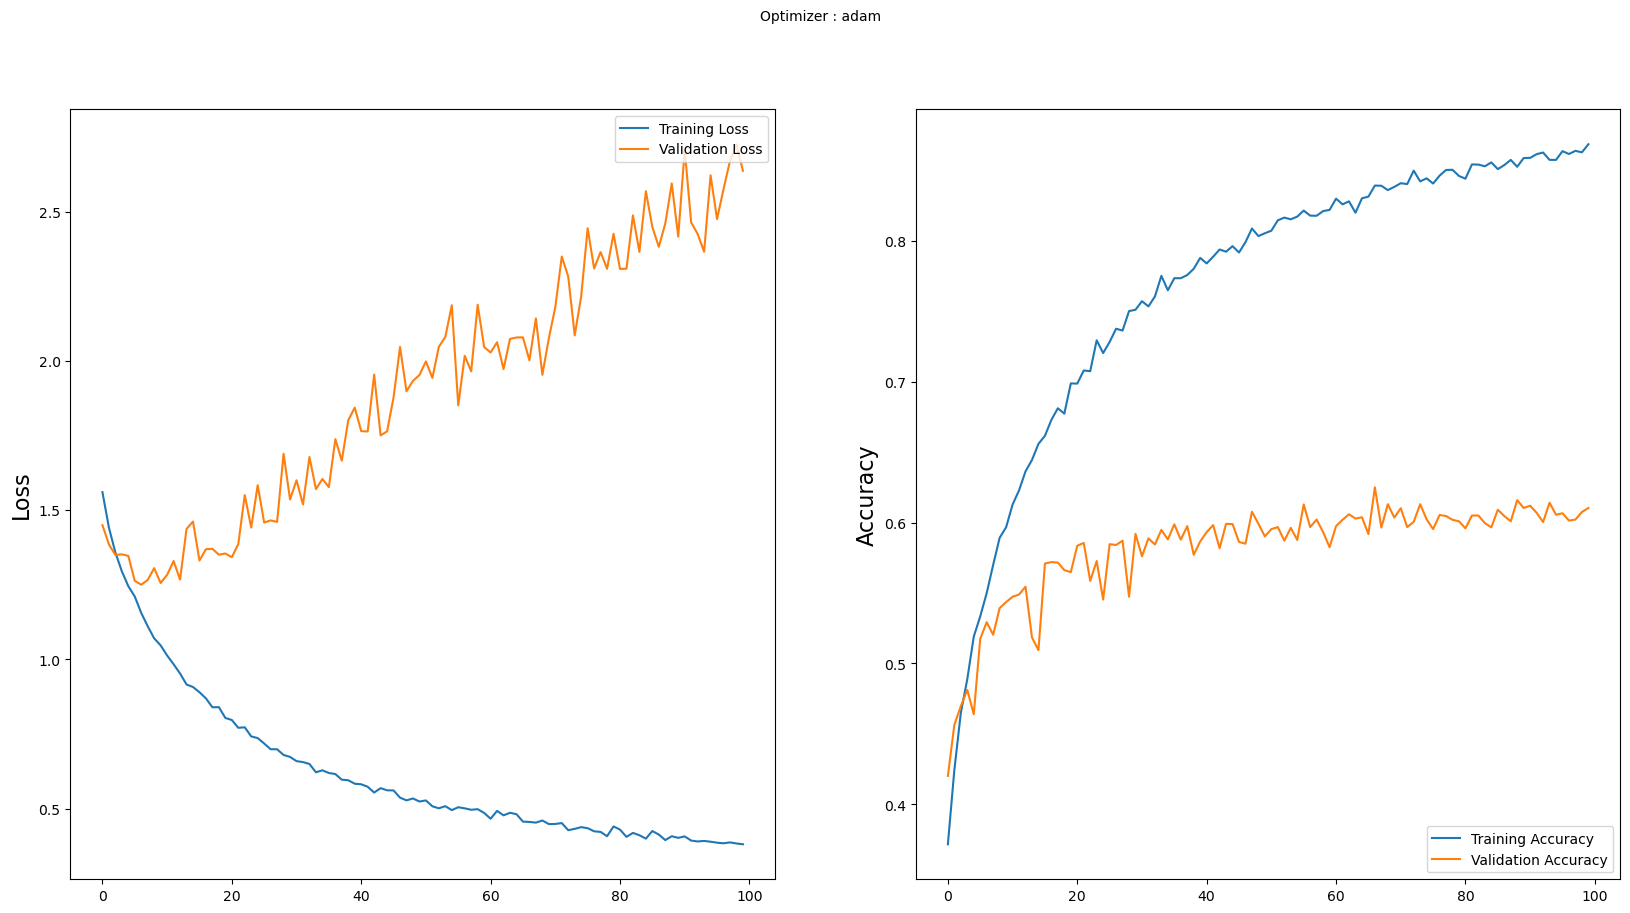

In [26]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [72]:
model = load_model('vgg16.h5', compile = False)
class_labels = list(test_set.class_indices.keys())

# Get true labels
y_true = test_set.classes  # Ground truth labels

# Get model predictions (probabilities)
y_pred_probs = model.predict(test_set)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

2801/2801 [==============================] - 18s 6ms/step


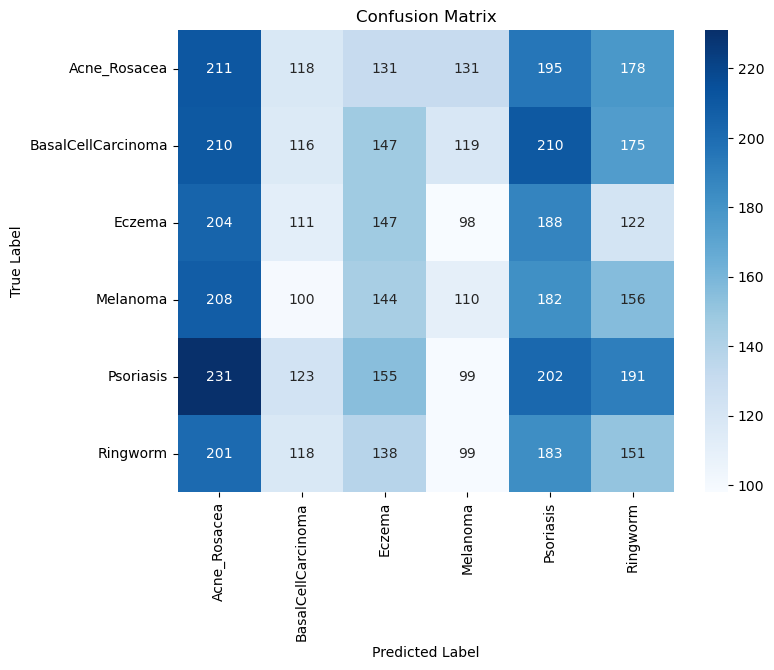

In [73]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

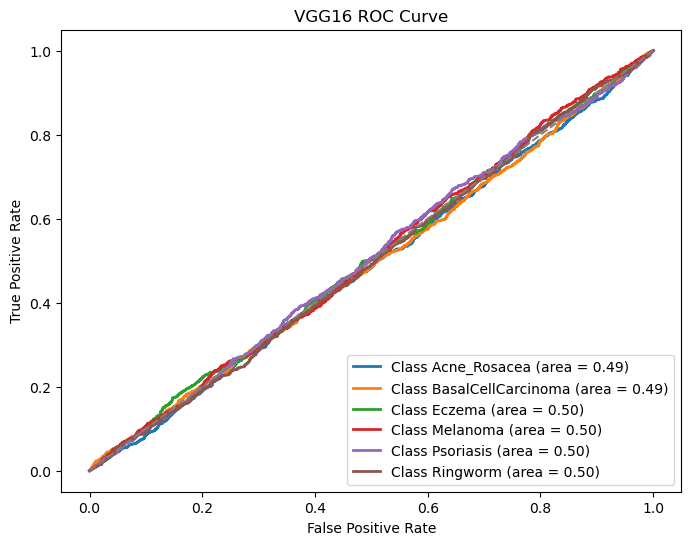

In [74]:
from sklearn.preprocessing import label_binarize

y_true_one_hot = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Compute ROC for each class
plt.figure(figsize=(8, 6))

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_labels[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Xception

In [27]:
from tensorflow.keras.applications import Xception, NASNetMobile, InceptionV3
from tensorflow.keras.layers import Activation, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [28]:
base_model = Xception(input_shape = IMAGE_SIZE + [3],weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model8 = Model(inputs=base_model.input, outputs=predictions)
model8.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=["accuracy",f1_m,precision_m, recall_m])
model8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [29]:
hist8 = model8.fit(train_set, validation_data=test_set, epochs=100, steps_per_epoch=len(train_set), validation_steps=len(test_set))#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/100
4199/4199 [==============================] - 127s 30ms/step - loss: 1.6609 - accuracy: 0.2915 - f1_m: 0.0587 - precision_m: 0.0876 - recall_m: 0.0442 - val_loss: 1.4585 - val_accuracy: 0.4240 - val_f1_m: 0.1192 - val_precision_m: 0.1733 - val_recall_m: 0.0921
Epoch 2/100
4199/4199 [==============================] - 119s 28ms/step - loss: 1.4120 - accuracy: 0.4424 - f1_m: 0.2470 - precision_m: 0.3551 - recall_m: 0.1929 - val_loss: 1.3003 - val_accuracy: 0.5064 - val_f1_m: 0.3709 - val_precision_m: 0.4873 - val_recall_m: 0.3127
Epoch 3/100
4199/4199 [==============================] - 121s 29ms/step - loss: 1.2681 - accuracy: 0.5148 - f1_m: 0.3610 - precision_m: 0.4920 - recall_m: 0.2954 - val_loss: 1.3008 - val_accuracy: 0.5166 - val_f1_m: 0.4045 - val_precision_m: 0.5187 - val_recall_m: 0.3474
Epoch 4/100
4199/4199 [==============================] - 121s 29ms/step - loss: 1.1332 - accuracy: 0.5771 - f1_m: 0.4575 - precision_m: 0.5826 - recall_m: 0.3950 - val_loss: 1.2871 - v

4199/4199 [==============================] - 119s 28ms/step - loss: 0.0899 - accuracy: 0.9675 - f1_m: 0.9667 - precision_m: 0.9700 - recall_m: 0.9651 - val_loss: 1.5502 - val_accuracy: 0.6391 - val_f1_m: 0.6320 - val_precision_m: 0.6532 - val_recall_m: 0.6214
Epoch 32/100
4199/4199 [==============================] - 119s 28ms/step - loss: 0.0835 - accuracy: 0.9724 - f1_m: 0.9715 - precision_m: 0.9742 - recall_m: 0.9702 - val_loss: 1.6247 - val_accuracy: 0.6300 - val_f1_m: 0.6256 - val_precision_m: 0.6458 - val_recall_m: 0.6155
Epoch 33/100
4199/4199 [==============================] - 118s 28ms/step - loss: 0.0756 - accuracy: 0.9728 - f1_m: 0.9728 - precision_m: 0.9754 - recall_m: 0.9715 - val_loss: 1.5367 - val_accuracy: 0.6510 - val_f1_m: 0.6464 - val_precision_m: 0.6669 - val_recall_m: 0.6362
Epoch 34/100
4199/4199 [==============================] - 115s 27ms/step - loss: 0.0727 - accuracy: 0.9751 - f1_m: 0.9749 - precision_m: 0.9764 - recall_m: 0.9742 - val_loss: 1.6384 - val_accura

4199/4199 [==============================] - 120s 28ms/step - loss: 0.0207 - accuracy: 0.9913 - f1_m: 0.9912 - precision_m: 0.9917 - recall_m: 0.9910 - val_loss: 1.9454 - val_accuracy: 0.6426 - val_f1_m: 0.6411 - val_precision_m: 0.6553 - val_recall_m: 0.6341
Epoch 92/100
4199/4199 [==============================] - 125s 30ms/step - loss: 0.0252 - accuracy: 0.9904 - f1_m: 0.9900 - precision_m: 0.9907 - recall_m: 0.9896 - val_loss: 1.7362 - val_accuracy: 0.6662 - val_f1_m: 0.6635 - val_precision_m: 0.6749 - val_recall_m: 0.6578
Epoch 93/100
4199/4199 [==============================] - 121s 29ms/step - loss: 0.0190 - accuracy: 0.9920 - f1_m: 0.9921 - precision_m: 0.9927 - recall_m: 0.9918 - val_loss: 2.0112 - val_accuracy: 0.6471 - val_f1_m: 0.6462 - val_precision_m: 0.6558 - val_recall_m: 0.6414
Epoch 94/100
4199/4199 [==============================] - 126s 30ms/step - loss: 0.0204 - accuracy: 0.9924 - f1_m: 0.9923 - precision_m: 0.9925 - recall_m: 0.9921 - val_loss: 1.9377 - val_accura

In [54]:
dl_acc = hist8.history["accuracy"][99]
dl_prec = hist8.history["precision_m"][99]
dl_rec = hist8.history["recall_m"][99]
dl_f1 = hist8.history["f1_m"][99]

storeResults('Train Acc - Xception',dl_acc,dl_prec,dl_rec,dl_f1)

In [55]:
dl_acc = hist8.history["val_accuracy"][99]
dl_prec = hist8.history["val_precision_m"][99]
dl_rec = hist8.history["val_recall_m"][99]
dl_f1 = hist8.history["val_f1_m"][99]

storeResults('Valid Acc - Xception',dl_acc,dl_prec,dl_rec,dl_f1)

In [31]:
model8.save('xception.h5')

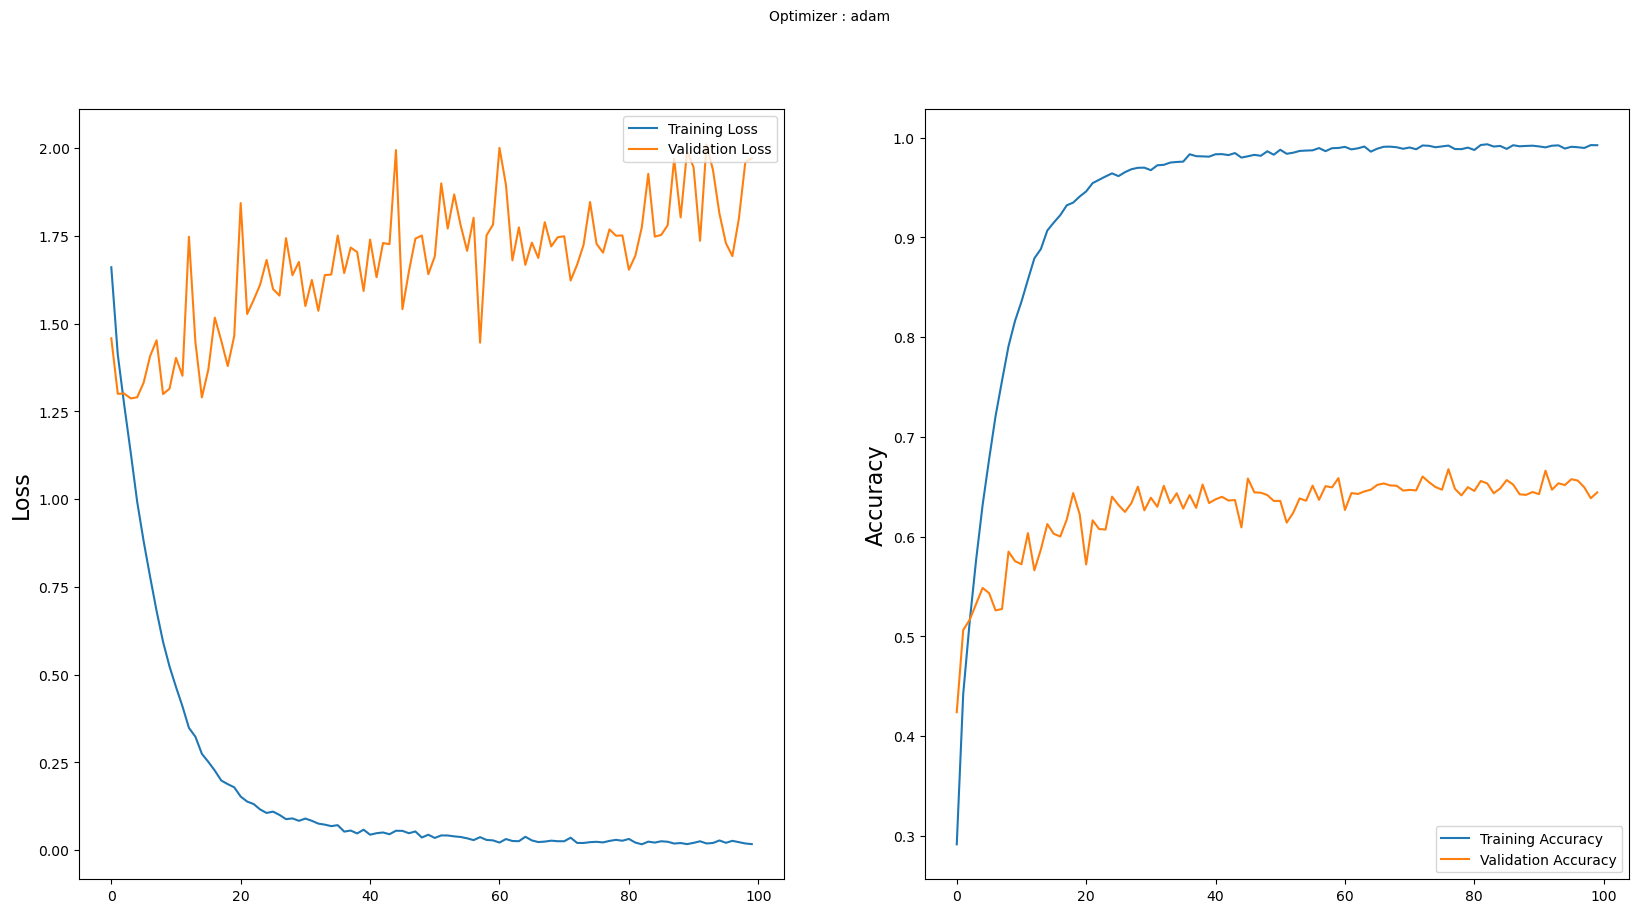

In [32]:
import matplotlib.pyplot as plt

x=hist8
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [76]:
model = load_model('xception.h5', compile = False)
class_labels = list(test_set.class_indices.keys())

# Get true labels
y_true = test_set.classes  # Ground truth labels

# Get model predictions (probabilities)
y_pred_probs = model.predict(test_set)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

2801/2801 [==============================] - 20s 7ms/step


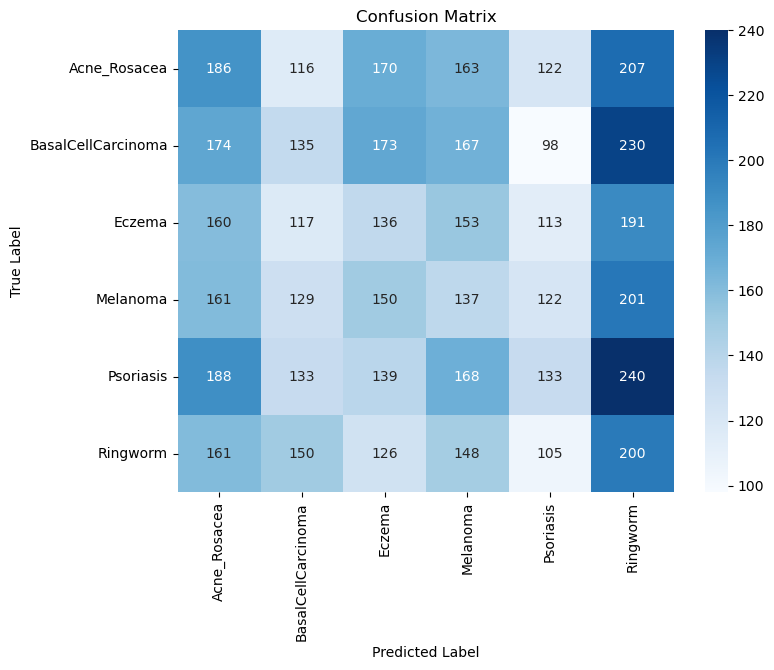

In [77]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

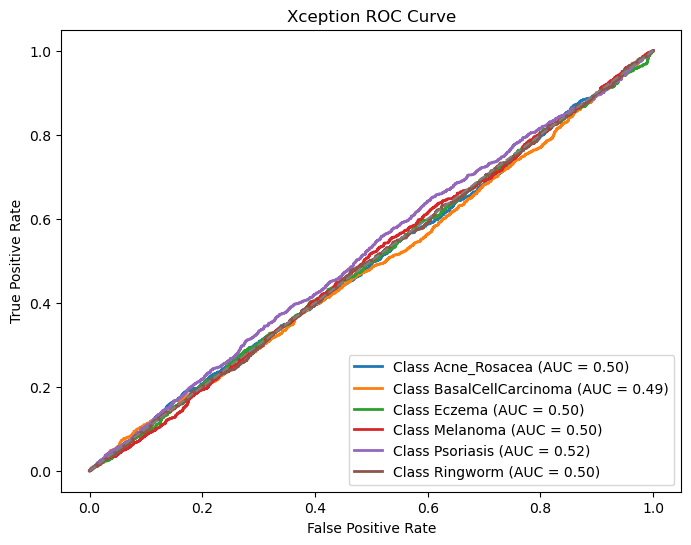

In [79]:
if len(class_labels) > 2:
    y_true_one_hot = label_binarize(y_true, classes=np.arange(len(class_labels)))

    plt.figure(figsize=(8, 6))

    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Xception ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


# NASNetMobile

In [33]:
base_model = NASNetMobile(input_shape = IMAGE_SIZE + [3],weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model9 = Model(inputs=base_model.input, outputs=predictions)
model9.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=["accuracy",f1_m,precision_m, recall_m])
model9.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 63, 63, 32)   864         ['input_4[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 63, 63, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)        (None, 63, 63, 32)   0           ['stem_bn1[0][0]']         

 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 32, 32, 11)  1152        ['separable_conv_1_pad_reduction_
 ht3_stem_1 (SeparableConv2D)                                    right3_stem_1[0][0]']            
                                                                                                  
 separable_conv_1_reduction_lef  (None, 32, 32, 11)  220         ['activation_9[0][0]']           
 t4_stem_1 (SeparableConv2D)                                                                      
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 11)   0           ['separable_conv_1_bn_reduction_r
          

                                                                                                  
 reduction_concat_stem_1 (Conca  (None, 32, 32, 44)  0           ['reduction_add_2_stem_1[0][0]', 
 tenate)                                                          'reduction_add3_stem_1[0][0]',  
                                                                  'add_12[0][0]',                 
                                                                  'reduction_add4_stem_1[0][0]']  
                                                                                                  
 adjust_avg_pool_1_stem_2 (Aver  (None, 32, 32, 32)  0           ['adjust_relu_1_stem_2[0][0]']   
 agePooling2D)                                                                                    
                                                                                                  
 adjust_avg_pool_2_stem_2 (Aver  (None, 32, 32, 32)  0           ['cropping2d[0][0]']             
 agePoolin

 reduction_add_1_stem_2 (Add)   (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft1_stem_2[0][0]',              
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight1_stem_2[0][0]']             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 16, 16, 22)  1562        ['separable_conv_1_pad_reduction_
 ht2_stem_2 (SeparableConv2D)                                    right2_stem_2[0][0]']            
                                                                                                  
 separable_conv_1_pad_reduction  (None, 35, 35, 22)  0           ['activation_18[0][0]']          
 _right3_stem_2 (ZeroPadding2D)                                                                   
          

 D)                                                                                               
                                                                                                  
 reduction_add3_stem_2 (Add)    (None, 16, 16, 22)   0           ['reduction_left3_stem_2[0][0]', 
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight3_stem_2[0][0]']             
                                                                                                  
 add_13 (Add)                   (None, 16, 16, 22)   0           ['reduction_add_2_stem_2[0][0]', 
                                                                  'reduction_left4_stem_2[0][0]'] 
                                                                                                  
 reduction_add4_stem_2 (Add)    (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
          

 activation_24 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_0[0][0]']                      
                                                                                                  
 activation_26 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_0[0][0]']                     
                                                                                                  
 activation_28 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_0[0][0]']                      
                                                                                                  
 activation_30 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
          

 activation_34 (Activation)     (None, 16, 16, 264)  0           ['normal_concat_0[0][0]']        
                                                                                                  
 adjust_conv_projection_1 (Conv  (None, 16, 16, 44)  3872        ['activation_33[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_conv_1_1 (Conv2D)       (None, 16, 16, 44)   11616       ['activation_34[0][0]']          
                                                                                                  
 adjust_bn_1 (BatchNormalizatio  (None, 16, 16, 44)  176         ['adjust_conv_projection_1[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right1_
 ht1_1 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left2_1
 t2_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right2_
 ht2_1 (Ba

 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right2  (None, 16, 16, 44)  2332        ['activation_53[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left5_  (None, 16, 16, 44)  2332        ['activation_55[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_1_normal_left1_2
 t1_2 (BatchNormalization)                                       [0][0]']                         
          

                                                                 2_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_2[0][0]']                     
                                                                                                  
 normal_add_3_2 (Add)           (None, 16, 16, 44)   0           ['normal_left3_2[0][0]',         
                                                                  'adjust_bn_2[0][0]']            
                                                                                                  
 normal_add_4_2 (Add)           (None, 16, 16, 44)   0           ['normal_left4_2[0][0]',         
                                                                  'normal_right4_2[0][0]']        
                                                                                                  
 normal_ad

                                                                 2_3[0][0]']                      
                                                                                                  
 activation_66 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_3[0][0]']                     
                                                                                                  
 activation_68 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 5_3[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 16, 16, 44)  3036        ['activation_60[0][0]']          
 3 (SeparableConv2D)                                                                              
          

                                                                                                  
 reduction_bn_1_reduce_4 (Batch  (None, 16, 16, 88)  352         ['reduction_conv_1_reduce_4[0][0]
 Normalization)                                                  ']                               
                                                                                                  
 adjust_bn_reduce_4 (BatchNorma  (None, 16, 16, 88)  352         ['adjust_conv_projection_reduce_4
 lization)                                                       [0][0]']                         
                                                                                                  
 activation_71 (Activation)     (None, 16, 16, 88)   0           ['reduction_bn_1_reduce_4[0][0]']
                                                                                                  
 activation_73 (Activation)     (None, 16, 16, 88)   0           ['adjust_bn_reduce_4[0][0]']     
          

 separable_conv_1_reduction_lef  (None, 8, 8, 88)    8536        ['activation_79[0][0]']          
 t4_reduce_4 (SeparableConv2D)                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 8, 8, 88)     0           ['separable_conv_1_bn_reduction_r
                                                                 ight2_reduce_4[0][0]']           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 8, 8, 88)    352         ['separable_conv_1_reduction_righ
 right3_reduce_4 (BatchNormaliz                                  t3_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable

                                                                  'reduction_add4_reduce_4[0][0]']
                                                                                                  
 adjust_avg_pool_1_5 (AveragePo  (None, 8, 8, 264)   0           ['adjust_relu_1_5[0][0]']        
 oling2D)                                                                                         
                                                                                                  
 adjust_avg_pool_2_5 (AveragePo  (None, 8, 8, 264)   0           ['cropping2d_2[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 adjust_conv_1_5 (Conv2D)       (None, 8, 8, 44)     11616       ['adjust_avg_pool_1_5[0][0]']    
                                                                                                  
 adjust_co

                                                                                                  
 separable_conv_2_normal_right1  (None, 8, 8, 88)    8536        ['activation_85[0][0]']          
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 8, 8, 88)    9944        ['activation_87[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_89[0][0]']          
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable

                                                                                                  
 activation_98 (Activation)     (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_100 (Activation)    (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_102 (Activation)    (None, 8, 8, 88)     0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 8, 8, 88)    9944        ['activation_94[0][0]']          
 6 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 2D)                                                                                              
                                                                                                  
 normal_right4_6 (AveragePoolin  (None, 8, 8, 88)    0           ['adjust_bn_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left5_6
 t5_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_6 (Add)           (None, 8, 8, 88)     0           ['separable_conv_2_bn_normal_left
                                                                 1_6[0][0]',                      
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 8, 8, 88)    352         ['separable_conv_1_normal_right2_
 ht2_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_1_normal_left5_7
 t5_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_107 (Activation)    (None, 8, 8, 88)     0           ['separable_conv_1_bn_normal_left
                                                                 1_7[0][0]']                      
                                                                                                  
 activatio

                                                                  'normal_add_2_7[0][0]',         
                                                                  'normal_add_3_7[0][0]',         
                                                                  'normal_add_4_7[0][0]',         
                                                                  'normal_add_5_7[0][0]']         
                                                                                                  
 activation_116 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_6[0][0]']        
                                                                                                  
 activation_117 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_7[0][0]']        
                                                                                                  
 adjust_conv_projection_8 (Conv  (None, 8, 8, 88)    46464       ['activation_116[0][0]']         
 2D)      

                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_125[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 8, 8, 88)    8536        ['activation_127[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left1_8
 t1_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 _right1_reduce_8 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 separable_conv_1_reduction_lef  (None, 4, 4, 176)   35376       ['separable_conv_1_pad_reduction_
 t1_reduce_8 (SeparableConv2D)                                   left1_reduce_8[0][0]']           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 4, 4, 176)   39600       ['separable_conv_1_pad_reduction_
 ht1_reduce_8 (SeparableConv2D)                                  right1_reduce_8[0][0]']          
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 4, 4, 176)   704         ['separable_conv_1_reduction_left
 left1_red

                                                                                                  
 separable_conv_2_reduction_rig  (None, 4, 4, 176)   39600       ['activation_135[0][0]']         
 ht2_reduce_8 (SeparableConv2D)                                                                   
                                                                                                  
 activation_137 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_r
                                                                 ight3_reduce_8[0][0]']           
                                                                                                  
 activation_139 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_l
                                                                 eft4_reduce_8[0][0]']            
                                                                                                  
 reduction

                                                                  'adjust_conv_2_9[0][0]']        
                                                                                                  
 normal_conv_1_9 (Conv2D)       (None, 4, 4, 176)    123904      ['activation_140[0][0]']         
                                                                                                  
 adjust_bn_9 (BatchNormalizatio  (None, 4, 4, 176)   704         ['concatenate_3[0][0]']          
 n)                                                                                               
                                                                                                  
 normal_bn_1_9 (BatchNormalizat  (None, 4, 4, 176)   704         ['normal_conv_1_9[0][0]']        
 ion)                                                                                             
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_2_normal_left2_9
 t2_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 normal_left3_9 (AveragePooling  (None, 4, 4, 176)   0           ['normal_bn_1_9[0][0]']          
 2D)      

 separable_conv_1_normal_right2  (None, 4, 4, 176)   32560       ['activation_159[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left5_  (None, 4, 4, 176)   32560       ['activation_161[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_1_normal_left1_1
 t1_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_1_normal_right1_
 ht1_10 (B

                                                                 t2_10[0][0]']                    
                                                                                                  
 normal_add_3_10 (Add)          (None, 4, 4, 176)    0           ['normal_left3_10[0][0]',        
                                                                  'adjust_bn_10[0][0]']           
                                                                                                  
 normal_add_4_10 (Add)          (None, 4, 4, 176)    0           ['normal_left4_10[0][0]',        
                                                                  'normal_right4_10[0][0]']       
                                                                                                  
 normal_add_5_10 (Add)          (None, 4, 4, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 5_10[0][0]',                     
          

 activation_172 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t2_11[0][0]']                    
                                                                                                  
 activation_174 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 5_11[0][0]']                     
                                                                                                  
 separable_conv_2_normal_left1_  (None, 4, 4, 176)   35376       ['activation_166[0][0]']         
 11 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 4, 4, 176)   32560       ['activation_168[0][0]']         
 _11 (Sepa

                                                                                                  
 normal_bn_1_12 (BatchNormaliza  (None, 4, 4, 176)   704         ['normal_conv_1_12[0][0]']       
 tion)                                                                                            
                                                                                                  
 activation_177 (Activation)    (None, 4, 4, 176)    0           ['normal_bn_1_12[0][0]']         
                                                                                                  
 activation_179 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activation_181 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 normal_left3_12 (AveragePoolin  (None, 4, 4, 176)   0           ['normal_bn_1_12[0][0]']         
 g2D)                                                                                             
                                                                                                  
 normal_left4_12 (AveragePoolin  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 normal_right4_12 (AveragePooli  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 ng2D)    

In [34]:
hist9 = model9.fit(train_set, validation_data=test_set, epochs=100, steps_per_epoch=len(train_set), validation_steps=len(test_set))#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/100
4199/4199 [==============================] - 544s 126ms/step - loss: 1.5920 - accuracy: 0.3543 - f1_m: 0.1271 - precision_m: 0.1840 - recall_m: 0.0986 - val_loss: 1.6694 - val_accuracy: 0.3072 - val_f1_m: 0.1241 - val_precision_m: 0.1806 - val_recall_m: 0.0959
Epoch 2/100
4199/4199 [==============================] - 527s 125ms/step - loss: 1.4200 - accuracy: 0.4435 - f1_m: 0.2506 - precision_m: 0.3526 - recall_m: 0.1996 - val_loss: 1.6677 - val_accuracy: 0.4002 - val_f1_m: 0.2879 - val_precision_m: 0.3738 - val_recall_m: 0.2449
Epoch 3/100
4199/4199 [==============================] - 527s 126ms/step - loss: 1.3065 - accuracy: 0.4940 - f1_m: 0.3342 - precision_m: 0.4515 - recall_m: 0.2755 - val_loss: 1.5350 - val_accuracy: 0.4595 - val_f1_m: 0.3625 - val_precision_m: 0.4556 - val_recall_m: 0.3160
Epoch 4/100
4199/4199 [==============================] - 528s 126ms/step - loss: 1.2331 - accuracy: 0.5307 - f1_m: 0.3957 - precision_m: 0.5243 - recall_m: 0.3314 - val_loss: 1.4750

Epoch 31/100
4199/4199 [==============================] - 535s 127ms/step - loss: 0.3269 - accuracy: 0.8863 - f1_m: 0.8795 - precision_m: 0.9018 - recall_m: 0.8683 - val_loss: 2.0745 - val_accuracy: 0.5536 - val_f1_m: 0.5425 - val_precision_m: 0.5830 - val_recall_m: 0.5223
Epoch 32/100
4199/4199 [==============================] - 523s 125ms/step - loss: 0.3259 - accuracy: 0.8888 - f1_m: 0.8818 - precision_m: 0.9052 - recall_m: 0.8701 - val_loss: 1.8263 - val_accuracy: 0.5705 - val_f1_m: 0.5646 - val_precision_m: 0.5941 - val_recall_m: 0.5498
Epoch 33/100
4199/4199 [==============================] - 535s 127ms/step - loss: 0.3137 - accuracy: 0.8896 - f1_m: 0.8843 - precision_m: 0.9044 - recall_m: 0.8743 - val_loss: 1.7624 - val_accuracy: 0.5677 - val_f1_m: 0.5608 - val_precision_m: 0.5946 - val_recall_m: 0.5439
Epoch 34/100
4199/4199 [==============================] - 524s 125ms/step - loss: 0.2841 - accuracy: 0.8997 - f1_m: 0.8958 - precision_m: 0.9140 - recall_m: 0.8868 - val_loss: 1.

Epoch 61/100
4199/4199 [==============================] - 531s 126ms/step - loss: 0.0982 - accuracy: 0.9664 - f1_m: 0.9653 - precision_m: 0.9695 - recall_m: 0.9632 - val_loss: 1.8522 - val_accuracy: 0.5969 - val_f1_m: 0.5916 - val_precision_m: 0.6187 - val_recall_m: 0.5780
Epoch 62/100
4199/4199 [==============================] - 525s 125ms/step - loss: 0.1031 - accuracy: 0.9637 - f1_m: 0.9630 - precision_m: 0.9668 - recall_m: 0.9611 - val_loss: 1.7785 - val_accuracy: 0.6144 - val_f1_m: 0.6075 - val_precision_m: 0.6408 - val_recall_m: 0.5909
Epoch 63/100
4199/4199 [==============================] - 531s 126ms/step - loss: 0.0967 - accuracy: 0.9665 - f1_m: 0.9663 - precision_m: 0.9688 - recall_m: 0.9650 - val_loss: 1.7299 - val_accuracy: 0.6260 - val_f1_m: 0.6231 - val_precision_m: 0.6435 - val_recall_m: 0.6128
Epoch 64/100
4199/4199 [==============================] - 533s 127ms/step - loss: 0.1056 - accuracy: 0.9627 - f1_m: 0.9614 - precision_m: 0.9649 - recall_m: 0.9596 - val_loss: 1.

Epoch 91/100
4199/4199 [==============================] - 529s 126ms/step - loss: 0.0561 - accuracy: 0.9801 - f1_m: 0.9800 - precision_m: 0.9815 - recall_m: 0.9793 - val_loss: 2.5044 - val_accuracy: 0.5855 - val_f1_m: 0.5818 - val_precision_m: 0.6016 - val_recall_m: 0.5719
Epoch 92/100
4199/4199 [==============================] - 526s 125ms/step - loss: 0.0624 - accuracy: 0.9789 - f1_m: 0.9786 - precision_m: 0.9798 - recall_m: 0.9780 - val_loss: 2.2643 - val_accuracy: 0.6178 - val_f1_m: 0.6126 - val_precision_m: 0.6289 - val_recall_m: 0.6044
Epoch 93/100
4199/4199 [==============================] - 532s 127ms/step - loss: 0.0523 - accuracy: 0.9790 - f1_m: 0.9786 - precision_m: 0.9802 - recall_m: 0.9777 - val_loss: 2.2028 - val_accuracy: 0.6319 - val_f1_m: 0.6272 - val_precision_m: 0.6417 - val_recall_m: 0.6200
Epoch 94/100
4199/4199 [==============================] - 526s 125ms/step - loss: 0.0592 - accuracy: 0.9787 - f1_m: 0.9784 - precision_m: 0.9795 - recall_m: 0.9779 - val_loss: 2.

In [56]:
dl_acc = hist9.history["accuracy"][99]
dl_prec = hist9.history["precision_m"][99]
dl_rec = hist9.history["recall_m"][99]
dl_f1 = hist9.history["f1_m"][99]

storeResults('Train Acc - NASNetMobile',dl_acc,dl_prec,dl_rec,dl_f1)

In [57]:
dl_acc = hist9.history["val_accuracy"][99]
dl_prec = hist9.history["val_precision_m"][99]
dl_rec = hist9.history["val_recall_m"][99]
dl_f1 = hist9.history["val_f1_m"][99]

storeResults('Valid Acc - NASNetMobile',dl_acc,dl_prec,dl_rec,dl_f1)

In [36]:
model9.save('nasnet.h5')

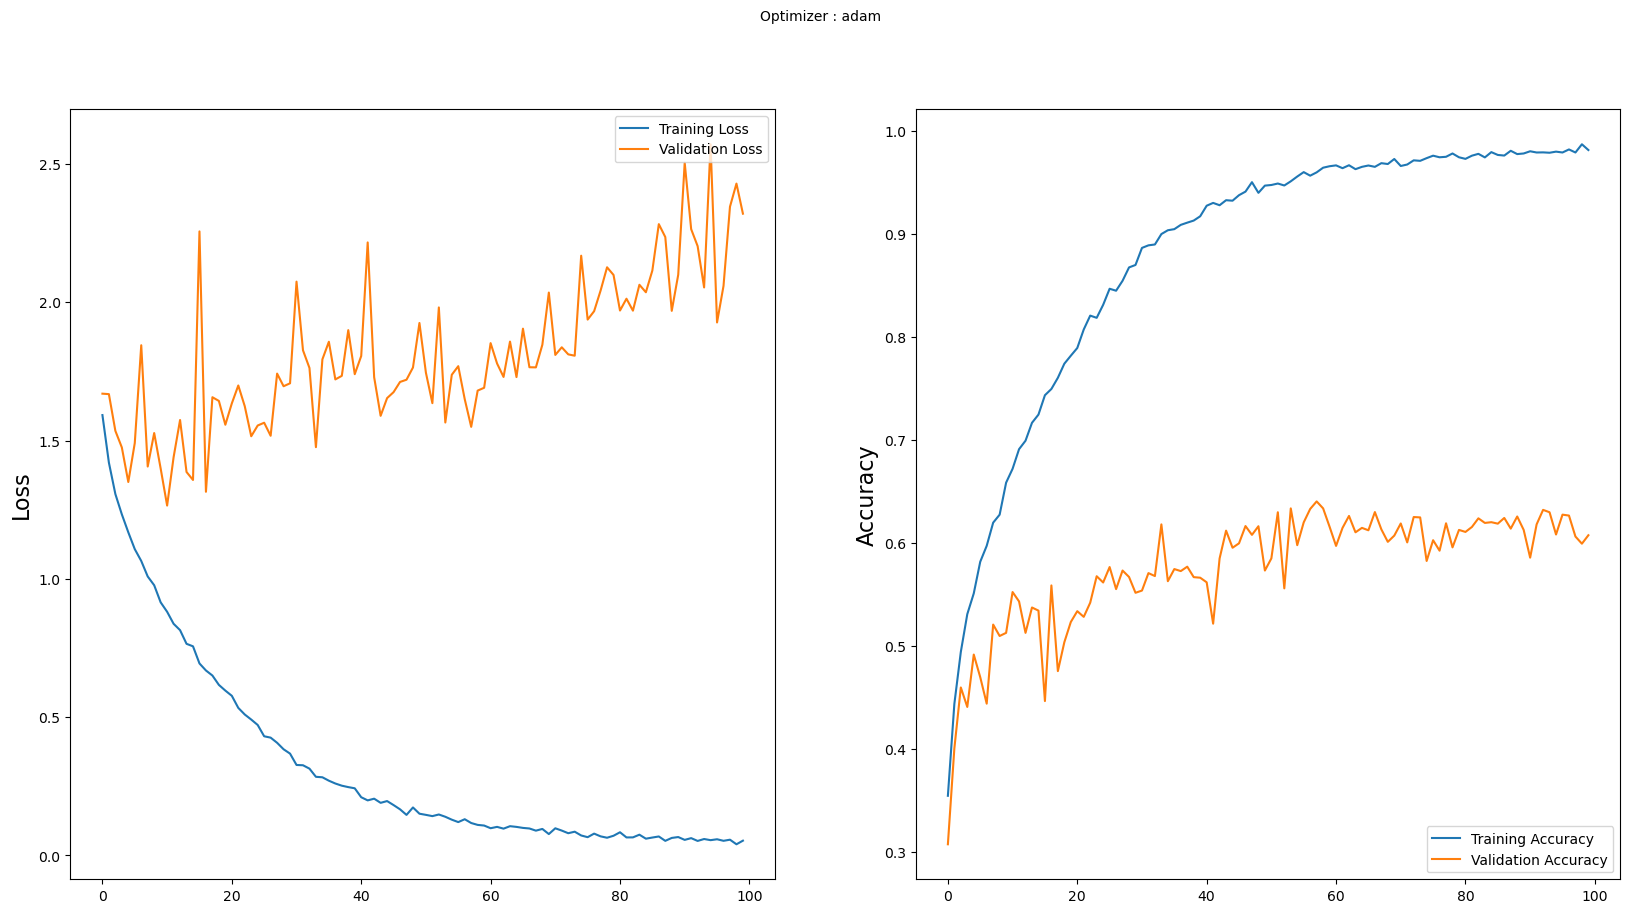

In [37]:
import matplotlib.pyplot as plt

x=hist9
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [80]:
model = load_model('nasnet.h5', compile = False)
class_labels = list(test_set.class_indices.keys())

# Get true labels
y_true = test_set.classes  # Ground truth labels

# Get model predictions (probabilities)
y_pred_probs = model.predict(test_set)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

2801/2801 [==============================] - 67s 23ms/step


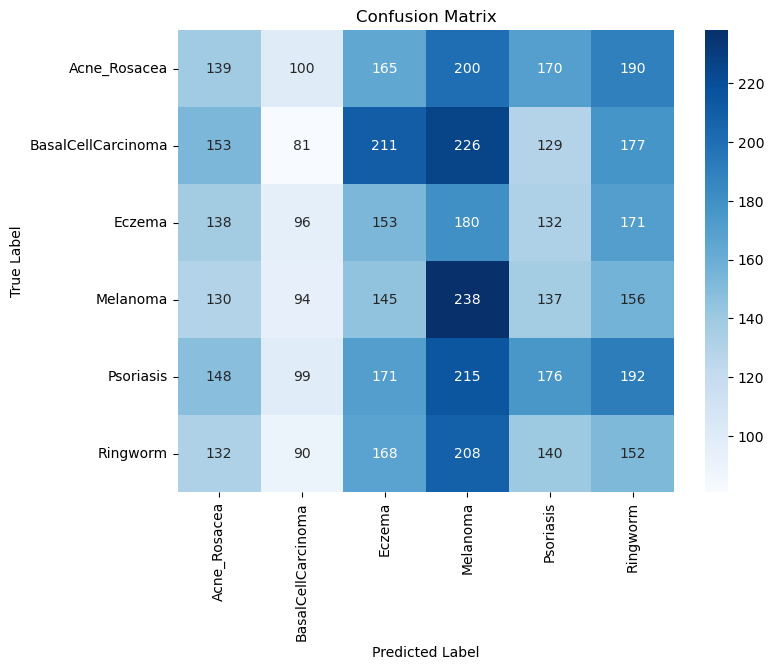

In [81]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

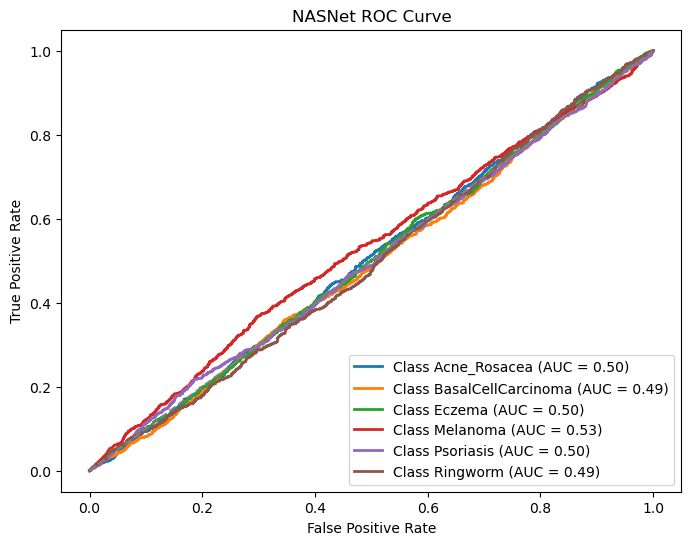

In [82]:
if len(class_labels) > 2:
    y_true_one_hot = label_binarize(y_true, classes=np.arange(len(class_labels)))

    plt.figure(figsize=(8, 6))

    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("NASNet ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


# Xception + NASNetMobile

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras

In [39]:
def ensemble():

    model_1 = load_model('xception.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('nasnet.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'NASNetMobile')
    
    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Extension')

    return simple_average

In [40]:
ext = ensemble()
ext.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
ext.summary()

Model: "Extension"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Xception (Functional)          (None, 6)            21913646    ['input_5[0][0]']                
                                                                                                  
 NASNetMobile (Functional)      (None, 6)            4813978     ['input_5[0][0]']                
                                                                                                  
 average (Average)              (None, 6)            0           ['Xception[0][0]',       

In [41]:
history = ext.fit(train_set, validation_data=test_set, epochs=100, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/100
4199/4199 [==============================] - 684s 159ms/step - loss: 0.0156 - accuracy: 0.9961 - f1_m: 0.9959 - precision_m: 0.9963 - recall_m: 0.9957 - val_loss: 1.4152 - val_accuracy: 0.6687 - val_f1_m: 0.6591 - val_precision_m: 0.7042 - val_recall_m: 0.6366
Epoch 2/100
4199/4199 [==============================] - 652s 155ms/step - loss: 0.0122 - accuracy: 0.9967 - f1_m: 0.9966 - precision_m: 0.9968 - recall_m: 0.9965 - val_loss: 1.4200 - val_accuracy: 0.6762 - val_f1_m: 0.6644 - val_precision_m: 0.7140 - val_recall_m: 0.6396
Epoch 3/100
4199/4199 [==============================] - 662s 158ms/step - loss: 0.0106 - accuracy: 0.9962 - f1_m: 0.9960 - precision_m: 0.9962 - recall_m: 0.9960 - val_loss: 1.4828 - val_accuracy: 0.6769 - val_f1_m: 0.6635 - val_precision_m: 0.7097 - val_recall_m: 0.6403
Epoch 4/100
4199/4199 [==============================] - 658s 157ms/step - loss: 0.0094 - accuracy: 0.9965 - f1_m: 0.9965 - precision_m: 0.9967 - recall_m: 0.9964 - val_loss: 1.4867

Epoch 31/100
4199/4199 [==============================] - 659s 157ms/step - loss: 0.0061 - accuracy: 0.9969 - f1_m: 0.9969 - precision_m: 0.9969 - recall_m: 0.9969 - val_loss: 1.6669 - val_accuracy: 0.6815 - val_f1_m: 0.6699 - val_precision_m: 0.7196 - val_recall_m: 0.6451
Epoch 32/100
4199/4199 [==============================] - 654s 156ms/step - loss: 0.0057 - accuracy: 0.9967 - f1_m: 0.9967 - precision_m: 0.9968 - recall_m: 0.9967 - val_loss: 1.6550 - val_accuracy: 0.6878 - val_f1_m: 0.6797 - val_precision_m: 0.7260 - val_recall_m: 0.6566
Epoch 33/100
4199/4199 [==============================] - 702s 167ms/step - loss: 0.0059 - accuracy: 0.9965 - f1_m: 0.9966 - precision_m: 0.9968 - recall_m: 0.9965 - val_loss: 1.6464 - val_accuracy: 0.6919 - val_f1_m: 0.6811 - val_precision_m: 0.7244 - val_recall_m: 0.6594
Epoch 34/100
4199/4199 [==============================] - 636s 151ms/step - loss: 0.0062 - accuracy: 0.9968 - f1_m: 0.9968 - precision_m: 0.9968 - recall_m: 0.9968 - val_loss: 1.

Epoch 61/100
4199/4199 [==============================] - 638s 152ms/step - loss: 0.0048 - accuracy: 0.9967 - f1_m: 0.9967 - precision_m: 0.9967 - recall_m: 0.9967 - val_loss: 1.7525 - val_accuracy: 0.6944 - val_f1_m: 0.6848 - val_precision_m: 0.7288 - val_recall_m: 0.6628
Epoch 62/100
4199/4199 [==============================] - 637s 152ms/step - loss: 0.0053 - accuracy: 0.9968 - f1_m: 0.9968 - precision_m: 0.9969 - recall_m: 0.9968 - val_loss: 1.7599 - val_accuracy: 0.6915 - val_f1_m: 0.6808 - val_precision_m: 0.7251 - val_recall_m: 0.6587
Epoch 63/100
4199/4199 [==============================] - 637s 152ms/step - loss: 0.0058 - accuracy: 0.9968 - f1_m: 0.9968 - precision_m: 0.9968 - recall_m: 0.9968 - val_loss: 1.7613 - val_accuracy: 0.6928 - val_f1_m: 0.6833 - val_precision_m: 0.7263 - val_recall_m: 0.6617
Epoch 64/100
4199/4199 [==============================] - 637s 152ms/step - loss: 0.0054 - accuracy: 0.9970 - f1_m: 0.9970 - precision_m: 0.9971 - recall_m: 0.9969 - val_loss: 1.

Epoch 91/100
4199/4199 [==============================] - 656s 156ms/step - loss: 0.0055 - accuracy: 0.9967 - f1_m: 0.9967 - precision_m: 0.9967 - recall_m: 0.9967 - val_loss: 1.7811 - val_accuracy: 0.6853 - val_f1_m: 0.6767 - val_precision_m: 0.7217 - val_recall_m: 0.6542
Epoch 92/100
4199/4199 [==============================] - 654s 156ms/step - loss: 0.0048 - accuracy: 0.9971 - f1_m: 0.9971 - precision_m: 0.9971 - recall_m: 0.9971 - val_loss: 1.7697 - val_accuracy: 0.6842 - val_f1_m: 0.6779 - val_precision_m: 0.7230 - val_recall_m: 0.6553
Epoch 93/100
4199/4199 [==============================] - 652s 155ms/step - loss: 0.0049 - accuracy: 0.9968 - f1_m: 0.9968 - precision_m: 0.9968 - recall_m: 0.9968 - val_loss: 1.7534 - val_accuracy: 0.6865 - val_f1_m: 0.6773 - val_precision_m: 0.7192 - val_recall_m: 0.6564
Epoch 94/100
4199/4199 [==============================] - 658s 157ms/step - loss: 0.0050 - accuracy: 0.9973 - f1_m: 0.9973 - precision_m: 0.9973 - recall_m: 0.9973 - val_loss: 1.

In [58]:
dl_acc = history.history["accuracy"][99]
dl_prec = history.history["precision_m"][99]
dl_rec = history.history["recall_m"][99]
dl_f1 = history.history["f1_m"][99]

storeResults('Train Acc - Ensemble',dl_acc,dl_prec,dl_rec,dl_f1)

In [59]:
dl_acc = history.history["val_accuracy"][99]
dl_prec = history.history["val_precision_m"][99]
dl_rec = history.history["val_recall_m"][99]
dl_f1 = history.history["val_f1_m"][99]

storeResults('Valid Acc - Ensemble',dl_acc,dl_prec,dl_rec,dl_f1)

In [50]:
ext.save('extension.h5')

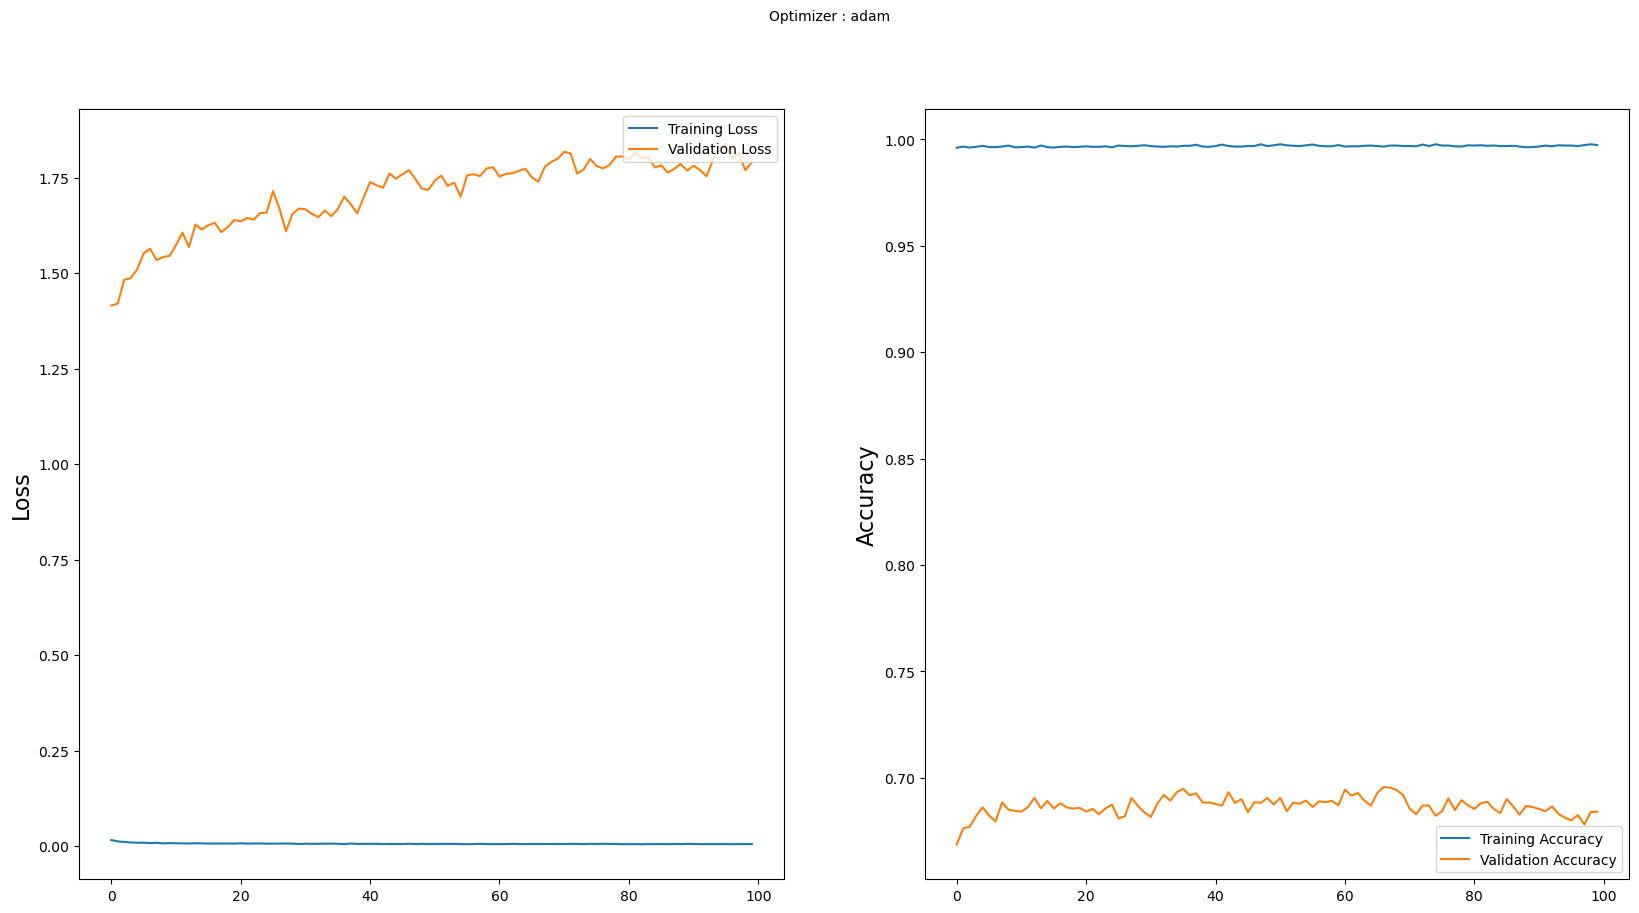

In [43]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [83]:
model = load_model('extension.h5', compile = False)
class_labels = list(test_set.class_indices.keys())

# Get true labels
y_true = test_set.classes  # Ground truth labels

# Get model predictions (probabilities)
y_pred_probs = model.predict(test_set)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

2801/2801 [==============================] - 81s 28ms/step


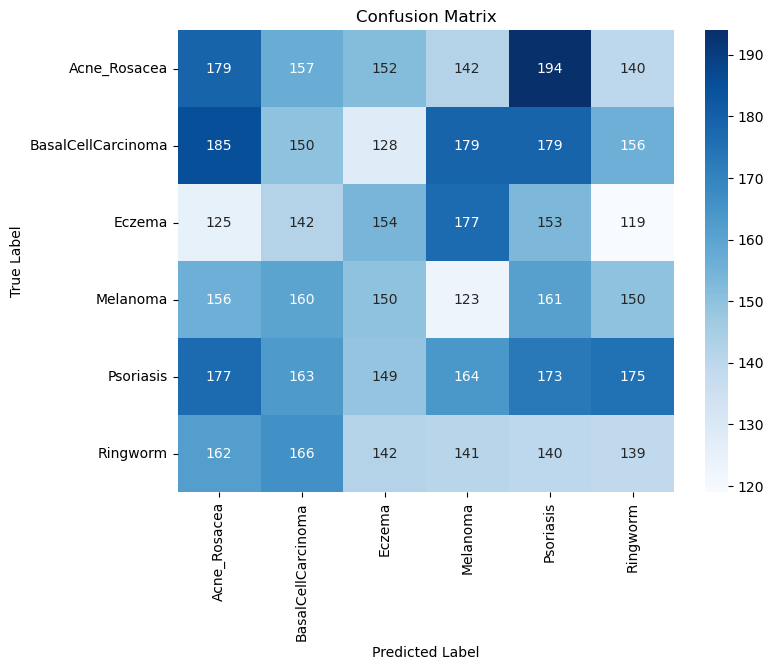

In [84]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

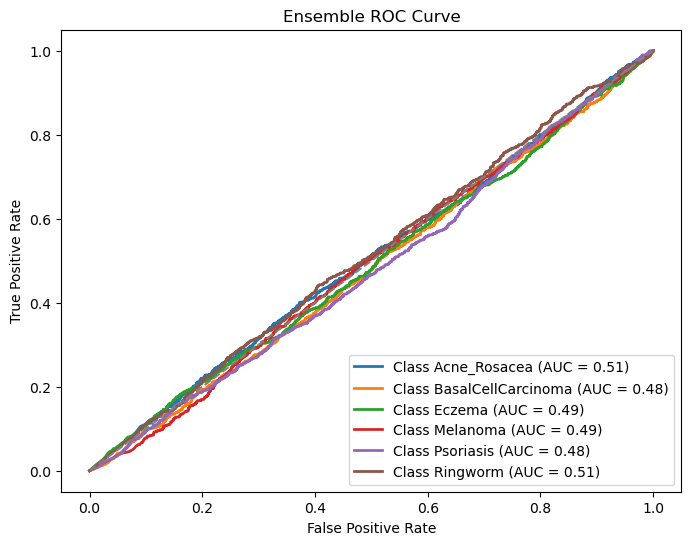

In [85]:
if len(class_labels) > 2:
    y_true_one_hot = label_binarize(y_true, classes=np.arange(len(class_labels)))

    plt.figure(figsize=(8, 6))

    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Ensemble ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


# Comparison

In [60]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score                   
                      })

In [61]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,Train Acc - VGG16,0.868,0.903,0.832,0.855
1,Valid Acc - VGG16,0.610,0.638,0.579,0.599
2,Train Acc - Xception,0.992,0.992,0.992,0.992
3,Valid Acc - Xception,0.644,0.651,0.637,0.641
4,Train Acc - NASNetMobile,0.981,0.982,0.980,0.981
5,Valid Acc - NASNetMobile,0.607,0.621,0.596,0.605
6,Train Acc - Ensemble,0.997,0.997,0.997,0.997
7,Valid Acc - Ensemble,0.684,0.725,0.657,0.679


# Graph

In [62]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

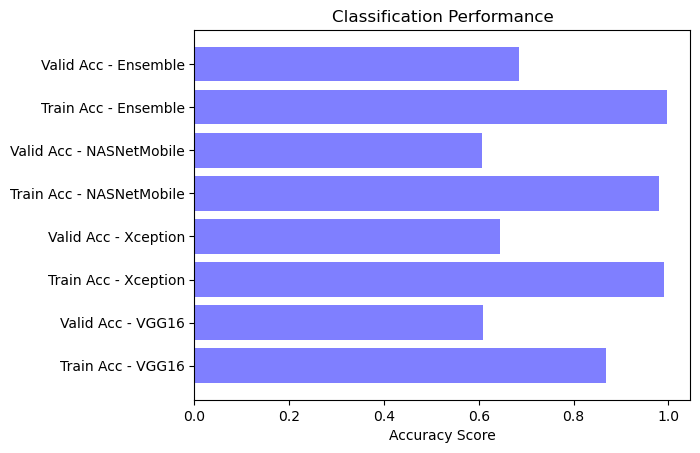

In [63]:
import matplotlib.pyplot as plt2

plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

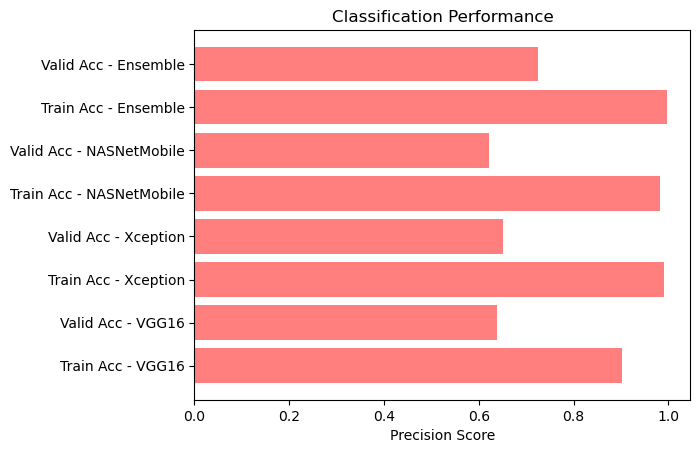

In [64]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

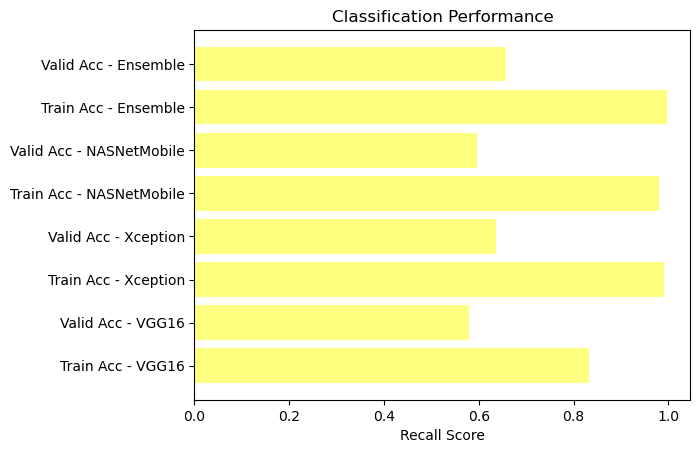

In [65]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

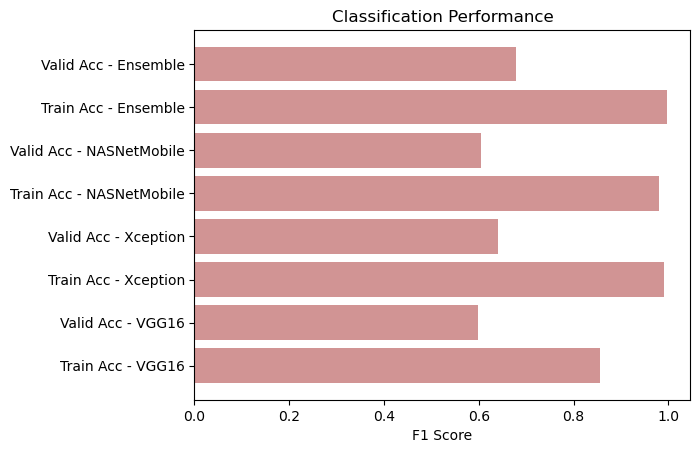

In [66]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='brown')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()